# Bayesian Network: AirBnb houses in Bologna
## Importing libraries

In [185]:
import pandas as pd
import numpy as np
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

print('Libraries imported')

Libraries imported


## Loading Airbnb database

In [186]:
listings = pd.read_csv("listings.csv")
listings.head(3)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,42196,https://www.airbnb.com/rooms/42196,20211217003510,2021-12-17,50 sm Studio in the historic centre,<b>The space</b><br />Really cozy and typical ...,NaN,https://a0.muscache.com/pictures/4775726/68044...,184487,https://www.airbnb.com/users/show/184487,...,4.85,4.85,4.70,NaN,t,1,1,0,0,1.32
1,46352,https://www.airbnb.com/rooms/46352,20211217003510,2021-12-17,A room in Pasolini's house,"Simple, cozy and silent room in a lived house ...",In the very nearby you have Via Saragozza whic...,https://a0.muscache.com/pictures/9f94acc3-98fc...,467810,https://www.airbnb.com/users/show/467810,...,4.79,4.80,4.59,NaN,f,2,0,2,0,2.20
2,59697,https://www.airbnb.com/rooms/59697,20211217003510,2021-12-17,COZY LARGE BEDROOM in the city center,"Cozy, spacious and bright double bedroom, in a...",NaN,https://a0.muscache.com/pictures/ac0528c4-b26f...,286688,https://www.airbnb.com/users/show/286688,...,4.79,4.82,4.66,NaN,f,2,0,2,0,2.18


## Preprocessing
1. Encoding amenities as one-hot array

In [187]:
listings = pd.concat([listings, listings['amenities'].str.get_dummies(sep='", "').astype(bool)[['Kitchen', 'Wifi']]], axis=1)
listings = listings.rename(columns = {'Kitchen': 'kitchen', 'Wifi': 'wifi'})
listings.head(3)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,kitchen,wifi
0,42196,https://www.airbnb.com/rooms/42196,20211217003510,2021-12-17,50 sm Studio in the historic centre,<b>The space</b><br />Really cozy and typical ...,NaN,https://a0.muscache.com/pictures/4775726/68044...,184487,https://www.airbnb.com/users/show/184487,...,4.70,NaN,t,1,1,0,0,1.32,True,False
1,46352,https://www.airbnb.com/rooms/46352,20211217003510,2021-12-17,A room in Pasolini's house,"Simple, cozy and silent room in a lived house ...",In the very nearby you have Via Saragozza whic...,https://a0.muscache.com/pictures/9f94acc3-98fc...,467810,https://www.airbnb.com/users/show/467810,...,4.59,NaN,f,2,0,2,0,2.20,True,False
2,59697,https://www.airbnb.com/rooms/59697,20211217003510,2021-12-17,COZY LARGE BEDROOM in the city center,"Cozy, spacious and bright double bedroom, in a...",NaN,https://a0.muscache.com/pictures/ac0528c4-b26f...,286688,https://www.airbnb.com/users/show/286688,...,4.66,NaN,f,2,0,2,0,2.18,True,False


2. Selecting relevant columns for the Bayesian Network

In [188]:
columns = ['id', 'neighbourhood_cleansed', 'room_type', 'accommodates', 'bathrooms_text', 'price', 'kitchen', 'wifi']
listings_selection = listings.loc[:, columns]
listings_selection.head(3)

,id,neighbourhood_cleansed,room_type,accommodates,bathrooms_text,price,kitchen,wifi
0,42196,Santo Stefano,Entire home/apt,2,1 bath,$68.00,True,False
1,46352,Porto - Saragozza,Private room,2,1 shared bath,$29.00,True,False
2,59697,Santo Stefano,Private room,2,1 shared bath,$50.00,True,False


3. Parsing price into float

In [189]:
listings_selection.loc[:, 'price'] = listings_selection.loc[:, 'price'].str.replace(r'[$|,]', '', regex=True).astype(float)
listings_selection.head(3)

,id,neighbourhood_cleansed,room_type,accommodates,bathrooms_text,price,kitchen,wifi
0,42196,Santo Stefano,Entire home/apt,2,1 bath,68.0,True,False
1,46352,Porto - Saragozza,Private room,2,1 shared bath,29.0,True,False
2,59697,Santo Stefano,Private room,2,1 shared bath,50.0,True,False


5. Encoding shared bathroom into boolean

In [190]:
listings_selection.loc[:, 'bathrooms_text'] = listings_selection.loc[:, 'bathrooms_text'].str.contains('shared')
listings_selection = listings_selection.rename(columns = {'bathrooms_text': 'shared_bathroom'})
listings_selection.head(3)

,id,neighbourhood_cleansed,room_type,accommodates,shared_bathroom,price,kitchen,wifi
0,42196,Santo Stefano,Entire home/apt,2,False,68.0,True,False
1,46352,Porto - Saragozza,Private room,2,True,29.0,True,False
2,59697,Santo Stefano,Private room,2,True,50.0,True,False


6. Discretizing price into 4 categories: '0-50', '50-150', '150-500', '>500'

In [191]:
listings_selection['price'], bins = pd.cut(listings_selection['price'], [0, 50, 150, 500, 10000], labels=['0-50', '50-150', '150-500', '>500'], retbins=True)
listings_selection.head(10)


,id,neighbourhood_cleansed,room_type,accommodates,shared_bathroom,price,kitchen,wifi
0,42196,Santo Stefano,Entire home/apt,2,False,50-150,True,False
1,46352,Porto - Saragozza,Private room,2,True,0-50,True,False
2,59697,Santo Stefano,Private room,2,True,0-50,True,False
3,85368,Santo Stefano,Entire home/apt,2,False,50-150,True,True
4,145779,Porto - Saragozza,Private room,1,True,0-50,False,False
5,209692,Navile,Private room,1,True,0-50,True,False
6,219878,Santo Stefano,Entire home/apt,2,False,50-150,True,True
7,229114,Navile,Entire home/apt,4,False,50-150,True,False
8,233922,Porto - Saragozza,Entire home/apt,5,False,50-150,True,True
9,246747,Porto - Saragozza,Private room,2,True,50-150,False,True


In [192]:
listings_selection.groupby(by='price').count()

,id,neighbourhood_cleansed,room_type,accommodates,shared_bathroom,kitchen,wifi
price,,,,,,,
0-50,813,813,813,813,813,813,813
50-150,2242,2242,2242,2242,2241,2242,2242
150-500,318,318,318,318,314,318,318
>500,80,80,80,80,80,80,80


7. Counting NaN values and removing them

In [193]:
print(f'Number of rows before cleaning: {listings_selection.shape[0]}')
listings_cleaned = listings_selection.dropna()
print(f'Number of rows after cleaning: {listings_clean.shape[0]}')

listings_cleaned.groupby(by='price').count()

Number of rows before cleaning: 3453
Number of rows after cleaning: 3448


,id,neighbourhood_cleansed,room_type,accommodates,shared_bathroom,kitchen,wifi
price,,,,,,,
0-50,813,813,813,813,813,813,813
50-150,2241,2241,2241,2241,2241,2241,2241
150-500,314,314,314,314,314,314,314
>500,80,80,80,80,80,80,80


8. Storing unique values and cardinalities

In [194]:
neighbourhood_v = listings_clean['neighbourhood_cleansed'].unique()
neighbourhood_c = len(neighbourhood_v)
print(f'Neighbourhood cardinality: {neighbourhood_c}\nNeighbourhood values: {neighbourhood_v}\n')

roomtype_v = listings_clean['room_type'].unique()
roomtype_c = len(roomtype_v)
print(f'Room type cardinality: {roomtype_c}\nRoom Type values: {roomtype_v}\n')

accommodates_v = listings_clean['accommodates'].unique()
accommodates_c = len(accommodates_v)
print(f'Accommodates cardinality: {accommodates_c}\nAccommodates values: {accommodates_v}\n')

sharedbathroom_v = [True, False]
sharedbathroom_c = 2
print(f'Shared bathroom cardinality: {sharedbathroom_c}\nShared bathroom values: {sharedbathroom_v}\n')

kitchen_v = [True, False]
kitchen_c = 2
print(f'Kitchen cardinality: {kitchen_c}\nKitchen values: {kitchen_v}\n')

wifi_v = [True, False]
wifi_c = 2
print(f'Wifi cardinality: {wifi_c}\nWifi values: {wifi_v}\n')

price_v = ['0-50', '50-150', '150-500', '>500']
price_c = 4
print(f'Price cardinality: {price_c}\nPrice values: {price_v}\n')

Neighbourhood cardinality: 6
Neighbourhood values: ['Santo Stefano' 'Porto - Saragozza' 'Navile' 'San Donato - San Vitale'
 'Savena' 'Borgo Panigale - Reno']

Room type cardinality: 4
Room Type values: ['Entire home/apt' 'Private room' 'Hotel room' 'Shared room']

Accommodates cardinality: 16
Accommodates values: [ 2  1  4  5  3  6  9  8  7 10 13 16 12 11 15 14]

Shared bathroom cardinality: 2
Shared bathroom values: [True, False]

Kitchen cardinality: 2
Kitchen values: [True, False]

Wifi cardinality: 2
Wifi values: [True, False]

Price cardinality: 4
Price values: ['0-50', '50-150', '150-500', '>500']



## Probabilities calculation
1. Splitting dataset in train and test

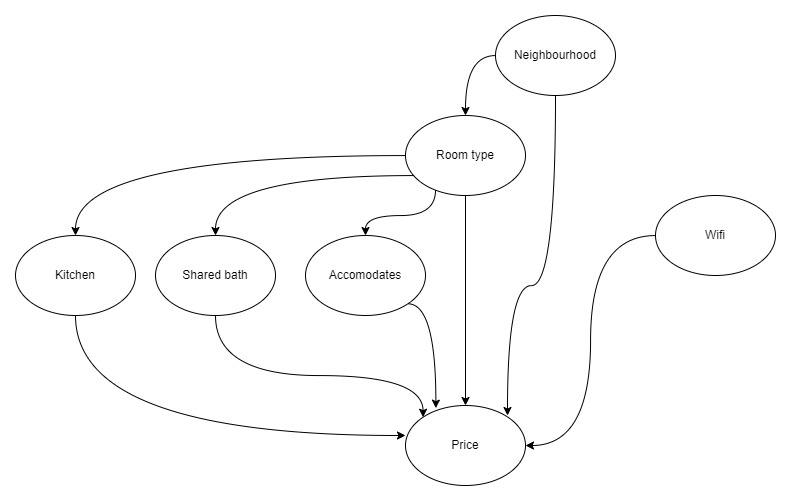

### Neighbourhood probability

In [196]:
neighbourhood_prob = listings_cleaned.groupby(['neighbourhood_cleansed']).count()[['id']] / listings_cleaned.shape[0]
display(neighbourhood_prob)

neighbourhood_prob = np.array(neighbourhood_prob).reshape((neighbourhood_c, 1))

,id
neighbourhood_cleansed,
Borgo Panigale - Reno,0.042343
Navile,0.116879
Porto - Saragozza,0.337877
San Donato - San Vitale,0.121520
Santo Stefano,0.345998
Savena,0.035383


### Wifi probability

In [197]:
wifi_prob = listings_cleaned.groupby(['wifi']).count()[['id']] / listings_cleaned.shape[0]
display(wifi_prob)

wifi_prob = np.array(wifi_prob).reshape((wifi_c, 1))

,id
wifi,
False,0.566125
True,0.433875


### Room type probability

In [198]:
roomtype_neighbourhood_count = listings_cleaned.groupby(['room_type', 'neighbourhood_cleansed']).size()
roomtype_neighbourhood_count

room_type        neighbourhood_cleansed 
Entire home/apt  Borgo Panigale - Reno      107
                 Navile                     250
                 Porto - Saragozza          842
                 San Donato - San Vitale    280
                 Santo Stefano              924
                 Savena                      73
Hotel room       Navile                       3
                 Porto - Saragozza           16
                 San Donato - San Vitale      1
                 Santo Stefano               27
Private room     Borgo Panigale - Reno       39
                 Navile                     149
                 Porto - Saragozza          297
                 San Donato - San Vitale    134
                 Santo Stefano              237
                 Savena                      47
Shared room      Navile                       1
                 Porto - Saragozza           10
                 San Donato - San Vitale      4
                 Santo Stefano                5

In [199]:
neighbourhood_count = listings_cleaned.groupby(['neighbourhood_cleansed']).size()
neighbourhood_count

neighbourhood_cleansed
Borgo Panigale - Reno       146
Navile                      403
Porto - Saragozza          1165
San Donato - San Vitale     419
Santo Stefano              1193
Savena                      122
dtype: int64

In [200]:
roomtype_prob = (roomtype_neighbourhood_count / neighbourhood_count).unstack(fill_value=0)
display(roomtype_prob)

neighbourhood_cleansed,Borgo Panigale - Reno,Navile,Porto - Saragozza,San Donato - San Vitale,Santo Stefano,Savena
room_type,,,,,,
Entire home/apt,0.732877,0.620347,0.722747,0.668258,0.774518,0.598361
Hotel room,0.000000,0.007444,0.013734,0.002387,0.022632,0.000000
Private room,0.267123,0.369727,0.254936,0.319809,0.198659,0.385246
Shared room,0.000000,0.002481,0.008584,0.009547,0.004191,0.016393


### Kitchen probability

In [201]:
kitchen_roomtype_count = listings_cleaned.groupby(['kitchen', 'room_type']).size()
kitchen_roomtype_count

kitchen  room_type      
False    Entire home/apt     145
         Hotel room           36
         Private room        410
         Shared room           5
True     Entire home/apt    2331
         Hotel room           11
         Private room        493
         Shared room          17
dtype: int64

In [202]:
roomtype_count = listings_cleaned.groupby(['room_type']).size()
roomtype_count

room_type
Entire home/apt    2476
Hotel room           47
Private room        903
Shared room          22
dtype: int64

In [203]:
kitchen_prob = (kitchen_roomtype_count / roomtype_count).unstack(fill_value=0)
display(kitchen_prob)

room_type,Entire home/apt,Hotel room,Private room,Shared room
kitchen,,,,
False,0.058562,0.765957,0.454042,0.227273
True,0.941438,0.234043,0.545958,0.772727


### Shared bath probability

In [204]:
sharedbath_roomtype_count = listings_cleaned.groupby(['shared_bathroom', 'room_type']).size()
sharedbath_roomtype_count

shared_bathroom  room_type      
False            Entire home/apt    2476
                 Hotel room           43
                 Private room        470
True             Hotel room            4
                 Private room        433
                 Shared room          22
dtype: int64

In [205]:
roomtype_count = listings_cleaned.groupby(['room_type']).size()
roomtype_count

room_type
Entire home/apt    2476
Hotel room           47
Private room        903
Shared room          22
dtype: int64

In [206]:
sharedbath_prob = (sharedbath_roomtype_count / roomtype_count).unstack(fill_value=0)
display(sharedbath_prob)

room_type,Entire home/apt,Hotel room,Private room,Shared room
shared_bathroom,,,,
False,1.0,0.914894,0.520487,0.0
True,0.0,0.085106,0.479513,1.0


### Accommodates probability

In [207]:
accommodates_roomtype_count = listings_cleaned.groupby(['accommodates', 'room_type']).size()
accommodates_roomtype_count

accommodates  room_type      
1             Entire home/apt     17
              Private room       137
              Shared room          6
2             Entire home/apt    583
              Hotel room          29
              Private room       599
              Shared room         12
3             Entire home/apt    443
              Hotel room           9
              Private room       104
              Shared room          3
4             Entire home/apt    945
              Hotel room           6
              Private room        49
              Shared room          1
5             Entire home/apt    204
              Hotel room           2
              Private room         4
6             Entire home/apt    170
              Private room         4
7             Entire home/apt     42
              Hotel room           1
              Private room         2
8             Entire home/apt     43
9             Entire home/apt      9
10            Entire home/apt      8
11      

In [208]:
roomtype_count = listings_cleaned.groupby(['room_type']).size()
roomtype_count

room_type
Entire home/apt    2476
Hotel room           47
Private room        903
Shared room          22
dtype: int64

In [209]:
accommodates_prob = (accommodates_roomtype_count / roomtype_count).unstack(fill_value=0)
display(accommodates_prob)

room_type,Entire home/apt,Hotel room,Private room,Shared room
accommodates,,,,
1,0.006866,0.000000,0.151717,0.272727
2,0.235460,0.617021,0.663344,0.545455
3,0.178918,0.191489,0.115172,0.136364
4,0.381664,0.127660,0.054264,0.045455
5,0.082391,0.042553,0.004430,0.000000
6,0.068659,0.000000,0.004430,0.000000
7,0.016963,0.021277,0.002215,0.000000
8,0.017367,0.000000,0.000000,0.000000
9,0.003635,0.000000,0.000000,0.000000


### Price probability

In [210]:
price_alltheother_count = listings_cleaned.groupby(['price', 'neighbourhood_cleansed', 'wifi', 'room_type', 'kitchen', 'shared_bathroom', 'accommodates']).size()
price_alltheother_count

price  neighbourhood_cleansed  wifi   room_type        kitchen  shared_bathroom  accommodates
0-50   Borgo Panigale - Reno   False  Entire home/apt  False    False            1               0
                                                                                 2               0
                                                                                 3               0
                                                                                 4               0
                                                                                 5               0
                                                                                                ..
>500   Savena                  True   Shared room      True     True             12              0
                                                                                 13              0
                                                                                 14              0
               

In [211]:
alltheother_count = listings_cleaned.groupby(['neighbourhood_cleansed', 'wifi', 'room_type', 'kitchen', 'shared_bathroom', 'accommodates']).size()
alltheother_count

neighbourhood_cleansed  wifi   room_type        kitchen  shared_bathroom  accommodates
Borgo Panigale - Reno   False  Entire home/apt  False    False            4                3
                                                True     False            1                2
                                                                          2               17
                                                                          3               14
                                                                          4               27
                                                                                          ..
Savena                  True   Private room     True     False            3                1
                                                         True             1                2
                                                                          2               11
                                                                          4 

In [217]:
price_prob = (price_alltheother_count / alltheother_count).unstack(fill_value=0)
price_prob = price_prob.fillna(0).T
display(price_prob)

neighbourhood_cleansed Borgo Panigale - Reno                                \
wifi                                   False                                 
room_type                    Entire home/apt                                 
kitchen                                False                                 
shared_bathroom                        False                                 
accommodates                              1    2    3         4    5    6    
price                                                                        
0-50                                     0.0  0.0  0.0  0.000000  0.0  0.0   
50-150                                   0.0  0.0  0.0  0.666667  0.0  0.0   
150-500                                  0.0  0.0  0.0  0.333333  0.0  0.0   
>500                                     0.0  0.0  0.0  0.000000  0.0  0.0   

neighbourhood_cleansed                      ...      Savena                 \
wifi                                        ...        True                  
room_type                                   ... Shared room                  
kitchen                                     ...        True                  
shared_bathroom                             ...        True                  
accommodates             7    8    9    10  ...          7    8    9    10   
price                                       ...                              
0-50                    0.0  0.0  0.0  0.0  ...         0.0  0.0  0.0  0.0   
50-150                  0.0  0.0  0.0  0.0  ...         0.0  0.0  0.0  0.0   
150-500                 0.0  0.0  0.0  0.0  ...         0.0  0.0  0.0  0.0   
>500                    0.0  0.0  0.0  0.0  ...         0.0  0.0  0.0  0.0   

neighbourhood_cleansed                                
wifi                                                  
room_type                                             
kitchen                                               
shared_bathroom                                       
accommodates             11   12   13   14   15   16  
price                                                 
0-50                    0.0  0.0  0.0  0.0  0.0  0.0  
50-150                  0.0  0.0  0.0  0.0  0.0  0.0  
150-500                 0.0  0.0  0.0  0.0  0.0  0.0  
>500                    0.0  0.0  0.0  0.0  0.0  0.0  

[4 rows x 3072 columns]

 ## Network

In [195]:
airbnb_model = BayesianNetwork([('Neighbourhood', 'Room type'), ('Neighbourhood', 'Price'),
                                ('Room type', 'Kitchen'), ('Room type', 'Shared bath'), ('Room type', 'Accommodates'), ('Room type', 'Price'),
                                ('Kitchen', 'Price'),
                                ('Shared bath', 'Price'),
                                ('Accommmodates', 'Price'),
                                ('Wifi', 'Price')])

In [218]:
neighbourhood_cpd = TabularCPD('Neighbourhood', neighbourhood_c, neighbourhood_prob)
wifi_cpd = TabularCPD('Wifi', wifi_c, wifi_prob)

roomtype_cpd = TabularCPD('Room type', roomtype_c, roomtype_prob, evidence=['Neighbourhood'], evidence_card=[neighbourhood_c])

kitchen_cpd = TabularCPD('Kitchen', kitchen_c, kitchen_prob, evidence=['Room type'], evidence_card=[roomtype_c])
sharedbath_cpd = TabularCPD('Shared bath', sharedbathroom_c, sharedbath_prob, evidence=['Room type'], evidence_card=[roomtype_c])
accommodates_cpd = TabularCPD('Accommodates', accommodates_c, accommodates_prob, evidence=['Room type'], evidence_card=[roomtype_c])

price_cpd = TabularCPD('Price', price_c, price_prob, evidence=['Neighbourhood', 'Wifi', 'Room type', 'Kitchen', 'Shared bath', 'Accommodates'], evidence_card=[neighbourhood_c, wifi_c, roomtype_c, kitchen_c, sharedbathroom_c, accommodates_c])

airbnb_model.add_cpds(neighbourhood_cpd,
                      wifi_cpd, 
                      roomtype_cpd,
                      kitchen_cpd,
                      sharedbath_cpd,
                      accommodates_cpd,
                      price_cpd)

In [221]:
airbnb_model.states

{'Neighbourhood': [0, 1, 2, 3, 4, 5],
 'Wifi': [0, 1],
 'Room type': [0, 1, 2, 3],
 'Kitchen': [0, 1],
 'Shared bath': [0, 1],
 'Accommodates': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 'Price': [0, 1, 2, 3]}

In [220]:
airbnb_model.check_model()

ValueError: CPD associated with Price doesn't have proper parents associated with it.